
# QGAN: (Q-Net) + GAN (G-Net and D-Net)

More specifically, we'll use Q-GAN to train an agent to play a game called [Cart-Pole](https://gym.openai.com/envs/CartPole-v0). In this game, a freely swinging pole is attached to a cart. The cart can move to the left and right, and the goal is to keep the pole upright as long as possible.

![Cart-Pole](assets/cart-pole.jpg)

We can simulate this game using [OpenAI Gym](https://gym.openai.com/). First, let's check out how OpenAI Gym works. Then, we'll get into training an agent to play the Cart-Pole game.

In [1]:
import numpy as np

In [2]:
# In this one we should define and detect GPUs for tensorflow
# GPUs or CPU
import tensorflow as tf

# Check TensorFlow Version
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.8.0
Default GPU Device: /device:GPU:0


>**Note:** Make sure you have OpenAI Gym cloned. Then run this command 'pip install -e gym/[all]'.

In [3]:
import gym
# Create the Cart-Pole game environment
env = gym.make('CartPole-v0')
# env = gym.make('CartPole-v1')
# env = gym.make('Acrobot-v1')
# env = gym.make('MountainCar-v0')
# env = gym.make('Pendulum-v0')
# env = gym.make('Blackjack-v0')
# env = gym.make('FrozenLake-v0')
# env = gym.make('AirRaid-ram-v0')
# env = gym.make('AirRaid-v0')
# env = gym.make('BipedalWalker-v2')
# env = gym.make('Copy-v0')
# env = gym.make('CarRacing-v0')
# env = gym.make('Ant-v2') #mujoco
# env = gym.make('FetchPickAndPlace-v1') # mujoco required!

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.


/home/arasdar/anaconda3/envs/env/lib/python3.6/site-packages/gym/__init__.py:22: UserWarning: DEPRECATION WARNING: to improve load times, gym no longer automatically loads gym.spaces. Please run "import gym.spaces" to load gym.spaces on your own. This warning will turn into an error in a future version of gym.
  warnings.warn('DEPRECATION WARNING: to improve load times, gym no longer automatically loads gym.spaces. Please run "import gym.spaces" to load gym.spaces on your own. This warning will turn into an error in a future version of gym.')


We interact with the simulation through `env`. To show the simulation running, you can use `env.render()` to render one frame. Passing in an action as an integer to `env.step` will generate the next step in the simulation.  You can see how many actions are possible from `env.action_space` and to get a random action you can use `env.action_space.sample()`. This is general to all Gym games. In the Cart-Pole game, there are two possible actions, moving the cart left or right. So there are two actions we can take, encoded as 0 and 1.

Run the code below to watch the simulation run.

In [4]:
env.reset()
rewards, states, actions, dones = [], [], [], []
for _ in range(10):
    #env.render()
    action = env.action_space.sample()
    state, reward, done, info = env.step(action) # take a random action
    states.append(state)
    rewards.append(reward)
    actions.append(action)
    dones.append(done)
    #     print('state, action, reward, done, info')
    #     print(state, action, reward, done, info)
    if done:
    #         print('state, action, reward, done, info')
    #         print(state, action, reward, done, info)
        states.append(state)
        rewards.append(reward)
        actions.append(action)
        dones.append(done)

To shut the window showing the simulation, use `env.close()`.

If you ran the simulation above, we can look at the rewards:

In [5]:
print(rewards[-20:])
print(np.array(rewards).shape, np.array(states).shape, np.array(actions).shape, np.array(dones).shape)
print(np.array(rewards).dtype, np.array(states).dtype, np.array(actions).dtype, np.array(dones).dtype)
print('actions:', np.max(np.array(actions)), np.min(np.array(actions)))
print('rewards min and max:', np.max(np.array(rewards)), np.min(np.array(rewards)))
print('state size:', np.array(states).shape, 
      'action size: {}'.format((np.max(np.array(actions)) - np.min(np.array(actions)))+1))

[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
(10,) (10, 4) (10,) (10,)
float64 float64 int64 bool
actions: 1 0
rewards min and max: 1.0 1.0
state size: (10, 4) action size: 2


The game resets after the pole has fallen past a certain angle. For each frame while the simulation is running, it returns a reward of 1.0. The longer the game runs, the more reward we get. Then, our network's goal is to maximize the reward by keeping the pole vertical. It will do this by moving the cart to the left and the right.

In [6]:
# Data of the model
def model_input(state_size):
    # Current states given: input data
    states = tf.placeholder(tf.float32, [None, state_size], name='states')
    
    # Current actions given: indices
    actions = tf.placeholder(tf.int32, [None], name='actions')
    
    # Next states given: next input data
    next_states = tf.placeholder(tf.float32, [None, state_size], name='next_states')
    
    # TargetQs/values
    targetQs = tf.placeholder(tf.float32, [None], name='targetQs')
    
    # returning the given data to the model
    return states, actions, next_states, targetQs

In [11]:
# Q: Qfunction/Encoder/Classifier
def qfunction(states, action_size, hidden_size, reuse=False, alpha=0.1, training=False):
    with tf.variable_scope('qfunction', reuse=reuse):        
        # First fully connected layer
        h1 = tf.layers.dense(inputs=states, units=hidden_size)
        bn1 = tf.layers.batch_normalization(h1, training=training)        
        nl1 = tf.maximum(alpha * bn1, bn1)
        
        # Second fully connected layer
        h2 = tf.layers.dense(inputs=nl1, units=hidden_size)
        bn2 = tf.layers.batch_normalization(h2, training=training)        
        nl2 = tf.maximum(alpha * bn2, bn2)
        
        # Output layer
        logits = tf.layers.dense(inputs=nl2, units=action_size)        
        #predictions = tf.nn.softmax(logits)

        # return actions logits: Sqeezed/compressed/represented states into actions size
        return logits

In [12]:
# G: Generator/Decoder: actions can be given actions, generated actions
def generator(states, actions, state_size, hidden_size, reuse=False, alpha=0.1, training=False):
    with tf.variable_scope('generator', reuse=reuse):
        # Fuse compressed states (actions fake) with actions (actions real)
        x_fused = tf.concat(axis=1, values=[states, actions]) # NxD: axis1=N, and axis2=D
        
        # First fully connected layer
        h1 = tf.layers.dense(inputs=x_fused, units=hidden_size)
        bn1 = tf.layers.batch_normalization(h1, training=training)        
        nl1 = tf.maximum(alpha * bn1, bn1)
        
        # Second fully connected layer
        h2 = tf.layers.dense(inputs=nl1, units=hidden_size)
        bn2 = tf.layers.batch_normalization(h2, training=training)        
        nl2 = tf.maximum(alpha * bn2, bn2)
        
        # Output layer
        logits = tf.layers.dense(inputs=nl2, units=state_size)        
        #predictions = tf.sigmoid(logits)

        # return next_states_logits
        return logits

In [13]:
# D: Descriminator/Reward function
def discriminator(states, actions, next_states, hidden_size, reuse=False, alpha=0.1, training=False):
    with tf.variable_scope('discriminator', reuse=reuse):
        # Fuse states, actions, and next states (St, at, St+1) and (St, ~at, ~St+1)
        x_fused = tf.concat(axis=1, values=[states, actions, next_states]) # NxD: axis1=N, and axis2=D

        # First fully connected layer
        h1 = tf.layers.dense(inputs=x_fused, units=hidden_size)
        bn1 = tf.layers.batch_normalization(h1, training=training)        
        nl1 = tf.maximum(alpha * bn1, bn1)
        
        # Second fully connected layer
        h2 = tf.layers.dense(inputs=nl1, units=hidden_size)
        bn2 = tf.layers.batch_normalization(h2, training=training)        
        nl2 = tf.maximum(alpha * bn2, bn2)
        
        #         # Fused compressed states, actions, and compressed next_states (all three in action size)
        #         #h3 = tf.layers.dense(inputs=nl2, units=action_size)
        #         h3_fused = tf.concat(axis=1, values=[states, actions, nl2])
        #         bn3 = tf.layers.batch_normalization(h3_fused, training=training)        
        #         nl3 = tf.maximum(alpha * bn3, bn3)
        
        # Output layer
        logits = tf.layers.dense(inputs=nl2, units=1)   
        #predictions = tf.sigmoid(logits)

        # return reward logits
        return logits

In [14]:
def model_loss(states, actions, next_states, targetQs, # model_input
               state_size, action_size, hidden_size): # model_init
    # DQN: Q-learning - Bellman equations: loss (targetQ - Q)^2
    actions_logits = qfunction(states=states, hidden_size=hidden_size, action_size=action_size)
    actions_real = tf.one_hot(indices=actions, depth=action_size)
    Qs = tf.reduce_sum(tf.multiply(actions_logits, actions_real), axis=1)
    q_loss = tf.reduce_mean(tf.square(targetQs - Qs))

    # GAN: Generate next states
    next_states_logits = generator(states=states, actions=actions_real, 
                                   state_size=state_size, hidden_size=hidden_size)
        
    # GAN: Discriminate between fake and real
    d_logits_fake = discriminator(states=states, actions=actions_real, next_states=next_states_logits, 
                                  hidden_size=hidden_size, reuse=False)
    d_logits_real = discriminator(states=states, actions=actions_real, next_states=next_states, 
                                  hidden_size=hidden_size, reuse=True)    

    # GAN: Adverserial training - G-learning -  Variational AE
    g_loss_reconst = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=next_states_logits, labels=tf.sigmoid(x=next_states)))
    
    # GAN: Adverserial training - G-learning -  Relavistic GAN
    g_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_logits_fake)))
    g_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.zeros_like(d_logits_real)))
    g_loss = g_loss_real + g_loss_fake + g_loss_reconst
    
    # GAN: Adverserial training - D-learning-  Standard GAN
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_logits_fake)))
    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_logits_real)))
    d_loss = d_loss_real + d_loss_fake
    
    # Rewards fake/real
    rewards_fake = tf.sigmoid(d_logits_fake)
    rewards_real = tf.sigmoid(d_logits_real)

    return actions_logits, q_loss, g_loss, d_loss, rewards_fake, rewards_real

In [15]:
def model_opt(q_loss, g_loss, d_loss, learning_rate):
    """
    Get optimization operations in order
    :param q_loss: Qfunction/Value loss Tensor for next action prediction
    :param g_loss: Generator/Decoder loss Tensor for next state prediction
    :param d_loss: Discriminator/Reward loss Tensor for current reward function
    :param learning_rate: Learning Rate Placeholder
    :return: A tuple of (qfunction training, generator training, discriminator training)
    """
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    q_vars = [var for var in t_vars if var.name.startswith('qfunction')] # Q: action At/at
    g_vars = [var for var in t_vars if var.name.startswith('generator')] # G: next state St/st
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')] # D: reward Rt/rt

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        q_opt = tf.train.AdamOptimizer(learning_rate).minimize(q_loss, var_list=q_vars)
        g_opt = tf.train.AdamOptimizer(learning_rate).minimize(g_loss, var_list=g_vars)
        d_opt = tf.train.AdamOptimizer(learning_rate).minimize(d_loss, var_list=d_vars)

    return q_opt, g_opt, d_opt

In [16]:
class QGAN:
    def __init__(self, state_size, action_size, hidden_size, learning_rate):

        # Data of the Model: make the data available inside the framework
        self.states, self.actions, self.next_states, self.targetQs = model_input(state_size=state_size)

        # Create the Model: calculating the loss and forwad pass
        self.actions_logits, self.q_loss, self.g_loss, self.d_loss, self.rewards_fake, self.rewards_real = model_loss(
            state_size=state_size, action_size=action_size, hidden_size=hidden_size, # model init parameters
            states=self.states, next_states=self.next_states, actions=self.actions, targetQs=self.targetQs) # model input data

        # Update the model: backward pass and backprop
        self.q_opt, self.g_opt, self.d_opt = model_opt(q_loss=self.q_loss, g_loss=self.g_loss, d_loss=self.d_loss, 
                                                       learning_rate=learning_rate)

## Experience replay

Reinforcement learning algorithms can have stability issues due to correlations between states. To reduce correlations when training, we can store the agent's experiences and later draw a random mini-batch of those experiences to train on. 

Here, we'll create a `Memory` object that will store our experiences, our transitions $<s, a, r, s'>$. This memory will have a maxmium capacity, so we can keep newer experiences in memory while getting rid of older experiences. Then, we'll sample a random mini-batch of transitions $<s, a, r, s'>$ and train on those.

Below, I've implemented a `Memory` object. If you're unfamiliar with `deque`, this is a double-ended queue. You can think of it like a tube open on both sides. You can put objects in either side of the tube. But if it's full, adding anything more will push an object out the other side. This is a great data structure to use for the memory buffer.

In [17]:
from collections import deque

class Memory():    
    def __init__(self, max_size = 1000):
        self.buffer = deque(maxlen=max_size)
    
    def add(self, experience):
        self.buffer.append(experience)
            
    def sample(self, batch_size):
        idx = np.random.choice(np.arange(len(self.buffer)), 
                               size=batch_size, 
                               replace=False)
        return [self.buffer[ii] for ii in idx]

## Exploration - Exploitation

To learn about the environment and rules of the game, the agent needs to explore by taking random actions. We'll do this by choosing a random action with some probability $\epsilon$ (epsilon).  That is, with some probability $\epsilon$ the agent will make a random action and with probability $1 - \epsilon$, the agent will choose an action from $Q(s,a)$. This is called an **$\epsilon$-greedy policy**.


At first, the agent needs to do a lot of exploring. Later when it has learned more, the agent can favor choosing actions based on what it has learned. This is called _exploitation_. We'll set it up so the agent is more likely to explore early in training, then more likely to exploit later in training.

## Q-Learning training algorithm

Putting all this together, we can list out the algorithm we'll use to train the network. We'll train the network in _episodes_. One *episode* is one simulation of the game. For this game, the goal is to keep the pole upright for 195 frames. So we can start a new episode once meeting that goal. The game ends if the pole tilts over too far, or if the cart moves too far the left or right. When a game ends, we'll start a new episode. Now, to train the agent:

* Initialize the memory $D$
* Initialize the action-value network $Q$ with random weights
* **For** episode = 1, $M$ **do**
  * **For** $t$, $T$ **do**
     * With probability $\epsilon$ select a random action $a_t$, otherwise select $a_t = \mathrm{argmax}_a Q(s,a)$
     * Execute action $a_t$ in simulator and observe reward $r_{t+1}$ and new state $s_{t+1}$
     * Store transition $<s_t, a_t, r_{t+1}, s_{t+1}>$ in memory $D$
     * Sample random mini-batch from $D$: $<s_j, a_j, r_j, s'_j>$
     * Set $\hat{Q}_j = r_j$ if the episode ends at $j+1$, otherwise set $\hat{Q}_j = r_j + \gamma \max_{a'}{Q(s'_j, a')}$
     * Make a gradient descent step with loss $(\hat{Q}_j - Q(s_j, a_j))^2$
  * **endfor**
* **endfor**

## Hyperparameters

One of the more difficult aspects of reinforcememt learning are the large number of hyperparameters. Not only are we tuning the network, but we're tuning the simulation.

In [18]:
print('state size:', np.array(states).shape[1], 
      'action size: {}'.format((np.max(np.array(actions)) - np.min(np.array(actions)))+1))

state size: 4 action size: 2


In [19]:
train_episodes = 2000          # max number of episodes to learn from
max_steps = 2000000000000000   # max steps in an episode
gamma = 0.99                   # future reward discount

# Exploration parameters
explore_start = 1.0            # exploration probability at start
explore_stop = 0.01            # minimum exploration probability 
decay_rate = 0.0001            # exponential decay rate for exploration prob

# Network parameters
state_size = 4                 # number of units for the input state/observation -- simulation
hidden_size = 64               # number of units in each Q-network hidden layer -- simulation
action_size = 2                # number of units for the output actions -- simulation

# Memory parameters
memory_size = 100000           # memory capacity
batch_size = 200               # experience mini-batch size
learning_rate = 0.001          # learning rate for adam

In [20]:
tf.reset_default_graph()

model = QGAN(state_size=state_size, action_size=action_size, hidden_size=hidden_size, learning_rate=learning_rate)

## Populate the experience memory

Here I'm re-initializing the simulation and pre-populating the memory. The agent is taking random actions and storing the transitions in memory. This will help the agent with exploring the game.

In [21]:
# Initialize the simulation
env.reset()

# Take one random step to get the pole and cart moving
state, reward, done, _ = env.step(env.action_space.sample())

# init memory
memory = Memory(max_size=memory_size)

# Make a bunch of random actions and store the experiences
for _ in range(batch_size):
    # Uncomment the line below to watch the simulation
    # env.render()

    # Make a random action
    action = env.action_space.sample()
    next_state, reward, done, _ = env.step(action)

    if done:
        # The simulation fails so no next state
        next_state = np.zeros(state.shape)
        
        # Add experience to memory
        memory.add((state, action, reward, next_state))
        
        # Start new episode
        env.reset()
        
        # Take one random step to get the pole and cart moving
        state, reward, done, _ = env.step(env.action_space.sample())
    else:
        # Add experience to memory
        memory.add((state, action, reward, next_state))
        state = next_state

## Training

Below we'll train our agent. If you want to watch it train, uncomment the `env.render()` line. This is slow because it's rendering the frames slower than the network can train. But, it's cool to watch the agent get better at the game.

In [22]:
# Now train with experiences
saver = tf.train.Saver()

# Total rewards and losses list for plotting
rewards_list, rewards_fake_list, rewards_real_list = [], [], []
q_loss_list, g_loss_list, d_loss_list = [], [], [] 

# TF session for training
with tf.Session() as sess:
    
    # Initialize variables
    sess.run(tf.global_variables_initializer())

    #     # Restore/load the trained model 
    #     #saver.restore(sess, 'checkpoints/model.ckpt')    
    #     saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    
    # Training episodes/epochs
    step = 0
    for ep in range(train_episodes):
        
        # Env/agent steps/batches/minibatches
        total_reward, rewards_fake_mean, rewards_real_mean = 0, 0, 0
        q_loss, g_loss, d_loss = 0, 0, 0
        t = 0
        while t < max_steps:
            step += 1
            
            # Uncomment this next line to watch the training
            # env.render() 
            
            # Explore or Exploit
            explore_p = explore_stop + (explore_start - explore_stop)*np.exp(-decay_rate*step) 
            if explore_p > np.random.rand():
                # Make a random action
                action = env.action_space.sample()
            else:
                # Get action from model
                feed_dict = {model.states: state.reshape((1, *state.shape))}
                actions_logits = sess.run(model.actions_logits, feed_dict)
                action = np.argmax(actions_logits)
            
            # Take action, get new state and reward
            next_state, reward, done, _ = env.step(action)
    
            # Cumulative reward
            total_reward += reward
            
            # Episode/epoch training is done/failed!
            if done:
                # the episode ends so no next state
                next_state = np.zeros(state.shape)
                t = max_steps
                
                print('-------------------------------------------------------------------------------')
                print('Episode: {}'.format(ep),
                      'Total reward: {}'.format(total_reward),
                      'Average reward fake: {}'.format(rewards_fake_mean),
                      'Average reward real: {}'.format(rewards_real_mean),
                      'Training q_loss: {:.4f}'.format(q_loss),
                      'Training g_loss: {:.4f}'.format(g_loss),
                      'Training d_loss: {:.4f}'.format(d_loss),
                      'Explore P: {:.4f}'.format(explore_p))
                print('-------------------------------------------------------------------------------')
                
                # total rewards and losses for plotting
                rewards_list.append((ep, total_reward))
                rewards_fake_list.append((ep, rewards_fake_mean))
                rewards_real_list.append((ep, rewards_real_mean))
                q_loss_list.append((ep, q_loss))
                g_loss_list.append((ep, g_loss))
                d_loss_list.append((ep, d_loss))
                
                # Add experience to memory
                memory.add((state, action, reward, next_state))
                
                # Start new episode
                env.reset()
                
                # Take one random step to get the pole and cart moving
                state, reward, done, _ = env.step(env.action_space.sample())

            else:
                # Add experience to memory
                memory.add((state, action, reward, next_state))
                state = next_state
                t += 1
            
            # Sample mini-batch from memory
            batch = memory.sample(batch_size)
            states = np.array([each[0] for each in batch])
            actions = np.array([each[1] for each in batch])
            #rewards = np.array([each[2] for each in batch])
            next_states = np.array([each[3] for each in batch])
            
            # Calculating real current reward and next action
            feed_dict = {model.states: states, model.actions: actions, model.next_states: next_states}
            next_actions_logits, rewards_fake, rewards_real = sess.run([model.actions_logits, 
                                                                        model.rewards_fake, model.rewards_real], 
                                                                       feed_dict)
            #             feed_dict={model.states: next_states}
            #             next_actions_logits = sess.run(model.actions_logits, feed_dict)

            # Mean/average fake and real rewards or rewarded generated/given actions
            rewards_fake_mean = np.mean(rewards_fake.reshape(-1))
            rewards_real_mean = np.mean(rewards_real.reshape(-1))
            
            # Set target_Qs to 0 for states where episode ends
            episode_ends = (next_states == np.zeros(states[0].shape)).all(axis=1)
            next_actions_logits[episode_ends] = (0, 0) # NOTE: action size

            # Bellman equation: Qt = Rt + max(Qt+1)
            #targetQs = rewards_fake.reshape(-1) + (gamma * np.max(next_actions_logits, axis=1))
            targetQs = rewards_real.reshape(-1) + (gamma * np.max(next_actions_logits, axis=1))

            # Updating/training/optimizing the model
            feed_dict = {model.states: states, model.actions: actions, model.next_states: next_states,
                         model.targetQs: targetQs}
            q_loss, _ = sess.run([model.q_loss, model.q_opt], feed_dict)
            g_loss, _ = sess.run([model.g_loss, model.g_opt], feed_dict)
            d_loss, _ = sess.run([model.d_loss, model.d_opt], feed_dict)
            
    # Save the trained model
    saver.save(sess, 'checkpoints/model.ckpt')

-------------------------------------------------------------------------------
Episode: 0 Total reward: 24.0 Average reward fake: 0.5200744867324829 Average reward real: 0.5155307650566101 Training q_loss: 0.3971 Training g_loss: 2.0785 Training d_loss: 1.4308 Explore P: 0.9976
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1 Total reward: 19.0 Average reward fake: 0.46569985151290894 Average reward real: 0.4442448318004608 Training q_loss: 1.0494 Training g_loss: 2.0789 Training d_loss: 1.4651 Explore P: 0.9958
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2 Total reward: 13.0 Average reward fake: 0.40071800351142883 Average reward real: 0.43023544549942017 Training q_loss: 1.4876 Training g_loss: 2.2417 Training d_loss: 1.3910 Explore P: 0.99

-------------------------------------------------------------------------------
Episode: 23 Total reward: 22.0 Average reward fake: 0.489157497882843 Average reward real: 0.49268093705177307 Training q_loss: 9.1418 Training g_loss: 2.0796 Training d_loss: 1.4199 Explore P: 0.9570
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 24 Total reward: 33.0 Average reward fake: 0.503702700138092 Average reward real: 0.5316231846809387 Training q_loss: 1.7019 Training g_loss: 2.1306 Training d_loss: 1.3649 Explore P: 0.9539
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 25 Total reward: 36.0 Average reward fake: 0.48223984241485596 Average reward real: 0.5281516909599304 Training q_loss: 1.8065 Training g_loss: 2.1812 Training d_loss: 1.3374 Explore P: 0.95

-------------------------------------------------------------------------------
Episode: 46 Total reward: 48.0 Average reward fake: 0.4491208791732788 Average reward real: 0.5697070956230164 Training q_loss: 0.7011 Training g_loss: 2.3521 Training d_loss: 1.1893 Explore P: 0.9070
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 47 Total reward: 13.0 Average reward fake: 0.43326106667518616 Average reward real: 0.5530596971511841 Training q_loss: 0.9087 Training g_loss: 2.3443 Training d_loss: 1.2015 Explore P: 0.9059
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 48 Total reward: 42.0 Average reward fake: 0.43280670046806335 Average reward real: 0.5641851425170898 Training q_loss: 2.2203 Training g_loss: 2.3937 Training d_loss: 1.1676 Explore P: 0.

-------------------------------------------------------------------------------
Episode: 69 Total reward: 17.0 Average reward fake: 0.5072810649871826 Average reward real: 0.5231478214263916 Training q_loss: 0.2091 Training g_loss: 2.2585 Training d_loss: 1.3817 Explore P: 0.8572
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 70 Total reward: 23.0 Average reward fake: 0.44214165210723877 Average reward real: 0.5665960907936096 Training q_loss: 1.2407 Training g_loss: 2.6482 Training d_loss: 1.2034 Explore P: 0.8552
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 71 Total reward: 10.0 Average reward fake: 0.45780280232429504 Average reward real: 0.5247656106948853 Training q_loss: 0.3758 Training g_loss: 2.4026 Training d_loss: 1.2986 Explore P: 0.

-------------------------------------------------------------------------------
Episode: 92 Total reward: 14.0 Average reward fake: 0.4931409955024719 Average reward real: 0.5119316577911377 Training q_loss: 0.3087 Training g_loss: 2.2799 Training d_loss: 1.3839 Explore P: 0.8231
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 93 Total reward: 19.0 Average reward fake: 0.4379398822784424 Average reward real: 0.5523155927658081 Training q_loss: 0.1325 Training g_loss: 2.6973 Training d_loss: 1.2215 Explore P: 0.8216
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 94 Total reward: 11.0 Average reward fake: 0.486075222492218 Average reward real: 0.4613844156265259 Training q_loss: 0.1940 Training g_loss: 2.1639 Training d_loss: 1.5194 Explore P: 0.820

-------------------------------------------------------------------------------
Episode: 116 Total reward: 39.0 Average reward fake: 0.421866774559021 Average reward real: 0.5698539614677429 Training q_loss: 1.3660 Training g_loss: 3.1337 Training d_loss: 1.1711 Explore P: 0.7799
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 117 Total reward: 42.0 Average reward fake: 0.4375053346157074 Average reward real: 0.5145783424377441 Training q_loss: 0.5039 Training g_loss: 2.6944 Training d_loss: 1.3009 Explore P: 0.7766
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 118 Total reward: 25.0 Average reward fake: 0.46482476592063904 Average reward real: 0.530358076095581 Training q_loss: 0.5512 Training g_loss: 2.5165 Training d_loss: 1.2988 Explore P: 0.

-------------------------------------------------------------------------------
Episode: 139 Total reward: 33.0 Average reward fake: 0.4383338987827301 Average reward real: 0.6287384033203125 Training q_loss: 0.2421 Training g_loss: 2.9405 Training d_loss: 1.1209 Explore P: 0.7374
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 140 Total reward: 12.0 Average reward fake: 0.4460321068763733 Average reward real: 0.5467967391014099 Training q_loss: 0.3585 Training g_loss: 2.6301 Training d_loss: 1.2815 Explore P: 0.7365
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 141 Total reward: 10.0 Average reward fake: 0.4899924397468567 Average reward real: 0.5239007472991943 Training q_loss: 0.6069 Training g_loss: 2.6568 Training d_loss: 1.3719 Explore P: 0

-------------------------------------------------------------------------------
Episode: 162 Total reward: 14.0 Average reward fake: 0.43842360377311707 Average reward real: 0.5960349440574646 Training q_loss: 0.3886 Training g_loss: 3.2362 Training d_loss: 1.1899 Explore P: 0.7040
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 163 Total reward: 12.0 Average reward fake: 0.441396027803421 Average reward real: 0.4977227747440338 Training q_loss: 0.1602 Training g_loss: 2.5612 Training d_loss: 1.3844 Explore P: 0.7032
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 164 Total reward: 15.0 Average reward fake: 0.3802146017551422 Average reward real: 0.6242033839225769 Training q_loss: 1.0448 Training g_loss: 3.2853 Training d_loss: 1.0089 Explore P: 0

-------------------------------------------------------------------------------
Episode: 185 Total reward: 18.0 Average reward fake: 0.29863280057907104 Average reward real: 0.547142744064331 Training q_loss: 1.3290 Training g_loss: 3.2555 Training d_loss: 1.1042 Explore P: 0.6776
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 186 Total reward: 15.0 Average reward fake: 0.34642401337623596 Average reward real: 0.6014474630355835 Training q_loss: 0.1141 Training g_loss: 2.9255 Training d_loss: 1.0604 Explore P: 0.6766
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 187 Total reward: 11.0 Average reward fake: 0.440654993057251 Average reward real: 0.5065370798110962 Training q_loss: 0.1792 Training g_loss: 2.8252 Training d_loss: 1.2946 Explore P: 0

-------------------------------------------------------------------------------
Episode: 209 Total reward: 15.0 Average reward fake: 0.32887816429138184 Average reward real: 0.5917524695396423 Training q_loss: 0.4056 Training g_loss: 3.2572 Training d_loss: 0.9627 Explore P: 0.6453
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 210 Total reward: 9.0 Average reward fake: 0.38035961985588074 Average reward real: 0.5170137882232666 Training q_loss: 0.7836 Training g_loss: 3.1762 Training d_loss: 1.3282 Explore P: 0.6447
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 211 Total reward: 12.0 Average reward fake: 0.2809331715106964 Average reward real: 0.6039592027664185 Training q_loss: 0.2670 Training g_loss: 3.7816 Training d_loss: 0.9188 Explore P: 

-------------------------------------------------------------------------------
Episode: 233 Total reward: 11.0 Average reward fake: 0.28682321310043335 Average reward real: 0.7581340670585632 Training q_loss: 2.9289 Training g_loss: 4.6700 Training d_loss: 0.8225 Explore P: 0.6191
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 234 Total reward: 21.0 Average reward fake: 0.4278433322906494 Average reward real: 0.5654083490371704 Training q_loss: 0.8766 Training g_loss: 3.1914 Training d_loss: 1.2975 Explore P: 0.6178
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 235 Total reward: 10.0 Average reward fake: 0.3270293176174164 Average reward real: 0.6825958490371704 Training q_loss: 0.8541 Training g_loss: 4.1669 Training d_loss: 0.9088 Explore P: 

-------------------------------------------------------------------------------
Episode: 256 Total reward: 17.0 Average reward fake: 0.34223297238349915 Average reward real: 0.6620774865150452 Training q_loss: 2.3506 Training g_loss: 4.4845 Training d_loss: 0.8654 Explore P: 0.5900
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 257 Total reward: 23.0 Average reward fake: 0.21788692474365234 Average reward real: 0.577564537525177 Training q_loss: 0.2854 Training g_loss: 4.4795 Training d_loss: 0.9700 Explore P: 0.5887
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 258 Total reward: 18.0 Average reward fake: 0.3678041100502014 Average reward real: 0.7474796175956726 Training q_loss: 0.6336 Training g_loss: 4.3613 Training d_loss: 0.9722 Explore P: 

-------------------------------------------------------------------------------
Episode: 280 Total reward: 16.0 Average reward fake: 0.23827318847179413 Average reward real: 0.6147610545158386 Training q_loss: 0.8479 Training g_loss: 4.0528 Training d_loss: 0.8874 Explore P: 0.5632
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 281 Total reward: 9.0 Average reward fake: 0.28248271346092224 Average reward real: 0.6878402829170227 Training q_loss: 0.8014 Training g_loss: 5.1958 Training d_loss: 0.9882 Explore P: 0.5627
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 282 Total reward: 13.0 Average reward fake: 0.32238534092903137 Average reward real: 0.5515738725662231 Training q_loss: 5.0307 Training g_loss: 4.6073 Training d_loss: 1.2805 Explore P:

-------------------------------------------------------------------------------
Episode: 303 Total reward: 16.0 Average reward fake: 0.34460777044296265 Average reward real: 0.7634963989257812 Training q_loss: 0.4222 Training g_loss: 7.1801 Training d_loss: 0.7780 Explore P: 0.5375
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 304 Total reward: 16.0 Average reward fake: 0.1670359969139099 Average reward real: 0.6986324787139893 Training q_loss: 0.4539 Training g_loss: 5.9458 Training d_loss: 0.6361 Explore P: 0.5366
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 305 Total reward: 11.0 Average reward fake: 0.2329384982585907 Average reward real: 0.7980712652206421 Training q_loss: 1.1876 Training g_loss: 6.9418 Training d_loss: 0.6712 Explore P: 

-------------------------------------------------------------------------------
Episode: 326 Total reward: 13.0 Average reward fake: 0.1943068951368332 Average reward real: 0.781719446182251 Training q_loss: 0.2837 Training g_loss: 7.5340 Training d_loss: 0.5003 Explore P: 0.5112
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 327 Total reward: 38.0 Average reward fake: 0.22249092161655426 Average reward real: 0.5852614641189575 Training q_loss: 0.2935 Training g_loss: 5.1564 Training d_loss: 0.9295 Explore P: 0.5093
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 328 Total reward: 36.0 Average reward fake: 0.34696415066719055 Average reward real: 0.5792971849441528 Training q_loss: 0.3675 Training g_loss: 5.1571 Training d_loss: 1.3131 Explore P: 

-------------------------------------------------------------------------------
Episode: 350 Total reward: 8.0 Average reward fake: 0.1993943154811859 Average reward real: 0.5506959557533264 Training q_loss: 1.1563 Training g_loss: 6.2591 Training d_loss: 0.9331 Explore P: 0.4874
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 351 Total reward: 12.0 Average reward fake: 0.2616831064224243 Average reward real: 0.8582804799079895 Training q_loss: 0.6684 Training g_loss: 7.1807 Training d_loss: 0.7827 Explore P: 0.4869
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 352 Total reward: 16.0 Average reward fake: 0.44565483927726746 Average reward real: 0.8762458562850952 Training q_loss: 0.3161 Training g_loss: 5.6447 Training d_loss: 1.3089 Explore P: 0

-------------------------------------------------------------------------------
Episode: 374 Total reward: 8.0 Average reward fake: 0.17520290613174438 Average reward real: 0.6513402462005615 Training q_loss: 1.0815 Training g_loss: 8.2490 Training d_loss: 0.7702 Explore P: 0.4681
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 375 Total reward: 22.0 Average reward fake: 0.2572738528251648 Average reward real: 0.6110408306121826 Training q_loss: 0.4324 Training g_loss: 5.3375 Training d_loss: 0.9792 Explore P: 0.4671
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 376 Total reward: 25.0 Average reward fake: 0.19619129598140717 Average reward real: 0.7308862209320068 Training q_loss: 1.3213 Training g_loss: 5.6479 Training d_loss: 0.6840 Explore P: 

-------------------------------------------------------------------------------
Episode: 397 Total reward: 35.0 Average reward fake: 0.25849276781082153 Average reward real: 0.7665274739265442 Training q_loss: 0.4970 Training g_loss: 5.2885 Training d_loss: 0.7133 Explore P: 0.4505
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 398 Total reward: 12.0 Average reward fake: 0.309444785118103 Average reward real: 0.7839697003364563 Training q_loss: 0.4802 Training g_loss: 8.0559 Training d_loss: 0.8135 Explore P: 0.4500
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 399 Total reward: 18.0 Average reward fake: 0.333089143037796 Average reward real: 0.5661079287528992 Training q_loss: 0.5944 Training g_loss: 5.4059 Training d_loss: 1.0224 Explore P: 0.

-------------------------------------------------------------------------------
Episode: 420 Total reward: 33.0 Average reward fake: 0.17928628623485565 Average reward real: 0.598011314868927 Training q_loss: 0.5300 Training g_loss: 7.6282 Training d_loss: 1.4008 Explore P: 0.4345
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 421 Total reward: 27.0 Average reward fake: 0.3458106219768524 Average reward real: 0.746140718460083 Training q_loss: 0.5006 Training g_loss: 9.7959 Training d_loss: 1.3203 Explore P: 0.4334
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 422 Total reward: 14.0 Average reward fake: 0.48665037751197815 Average reward real: 0.567298948764801 Training q_loss: 1.5546 Training g_loss: 7.3222 Training d_loss: 1.6579 Explore P: 0.

-------------------------------------------------------------------------------
Episode: 444 Total reward: 7.0 Average reward fake: 0.23094631731510162 Average reward real: 0.6901432275772095 Training q_loss: 0.6519 Training g_loss: 9.1009 Training d_loss: 0.7416 Explore P: 0.4183
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 445 Total reward: 19.0 Average reward fake: 0.25024405121803284 Average reward real: 0.5036270618438721 Training q_loss: 0.9373 Training g_loss: 6.7908 Training d_loss: 1.5082 Explore P: 0.4175
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 446 Total reward: 20.0 Average reward fake: 0.2331334352493286 Average reward real: 0.7789623141288757 Training q_loss: 0.2975 Training g_loss: 7.8668 Training d_loss: 0.6841 Explore P: 

-------------------------------------------------------------------------------
Episode: 468 Total reward: 9.0 Average reward fake: 0.2049536556005478 Average reward real: 0.6100051999092102 Training q_loss: 0.4278 Training g_loss: 7.6640 Training d_loss: 0.9327 Explore P: 0.3973
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 469 Total reward: 14.0 Average reward fake: 0.31038203835487366 Average reward real: 0.5618863105773926 Training q_loss: 0.6117 Training g_loss: 6.8046 Training d_loss: 1.0094 Explore P: 0.3967
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 470 Total reward: 13.0 Average reward fake: 0.3583931624889374 Average reward real: 0.735291600227356 Training q_loss: 0.5497 Training g_loss: 9.4825 Training d_loss: 1.0151 Explore P: 0.

-------------------------------------------------------------------------------
Episode: 492 Total reward: 10.0 Average reward fake: 0.11029622703790665 Average reward real: 0.43020308017730713 Training q_loss: 0.3474 Training g_loss: 7.1863 Training d_loss: 1.3337 Explore P: 0.3823
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 493 Total reward: 10.0 Average reward fake: 0.20969554781913757 Average reward real: 0.692308247089386 Training q_loss: 0.5762 Training g_loss: 9.2919 Training d_loss: 1.1016 Explore P: 0.3819
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 494 Total reward: 31.0 Average reward fake: 0.14617377519607544 Average reward real: 0.5517301559448242 Training q_loss: 1.1279 Training g_loss: 8.6705 Training d_loss: 0.8405 Explore P

-------------------------------------------------------------------------------
Episode: 515 Total reward: 34.0 Average reward fake: 0.2556488513946533 Average reward real: 0.6910946369171143 Training q_loss: 0.1441 Training g_loss: 6.8895 Training d_loss: 0.8531 Explore P: 0.3677
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 516 Total reward: 15.0 Average reward fake: 0.14462000131607056 Average reward real: 0.7438821196556091 Training q_loss: 1.2051 Training g_loss: 7.1317 Training d_loss: 0.5978 Explore P: 0.3672
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 517 Total reward: 41.0 Average reward fake: 0.1567060798406601 Average reward real: 0.8487935662269592 Training q_loss: 1.4232 Training g_loss: 10.1072 Training d_loss: 0.4229 Explore P:

-------------------------------------------------------------------------------
Episode: 538 Total reward: 15.0 Average reward fake: 0.08859870582818985 Average reward real: 0.6168225407600403 Training q_loss: 6.0925 Training g_loss: 10.1856 Training d_loss: 0.6746 Explore P: 0.3529
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 539 Total reward: 10.0 Average reward fake: 0.29128801822662354 Average reward real: 0.8024684190750122 Training q_loss: 0.2425 Training g_loss: 9.2486 Training d_loss: 1.0351 Explore P: 0.3526
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 540 Total reward: 8.0 Average reward fake: 0.16606466472148895 Average reward real: 0.7015129327774048 Training q_loss: 0.4995 Training g_loss: 7.6911 Training d_loss: 0.6282 Explore P

-------------------------------------------------------------------------------
Episode: 562 Total reward: 20.0 Average reward fake: 0.18713033199310303 Average reward real: 0.6824803352355957 Training q_loss: 0.6912 Training g_loss: 8.9774 Training d_loss: 0.7020 Explore P: 0.3395
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 563 Total reward: 9.0 Average reward fake: 0.2634578347206116 Average reward real: 0.705880343914032 Training q_loss: 2.0435 Training g_loss: 7.8881 Training d_loss: 0.9516 Explore P: 0.3392
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 564 Total reward: 19.0 Average reward fake: 0.19987986981868744 Average reward real: 0.6873023509979248 Training q_loss: 1.1621 Training g_loss: 9.1756 Training d_loss: 0.7964 Explore P: 0

-------------------------------------------------------------------------------
Episode: 585 Total reward: 14.0 Average reward fake: 0.28322833776474 Average reward real: 0.6859259009361267 Training q_loss: 0.6197 Training g_loss: 7.6595 Training d_loss: 1.2598 Explore P: 0.3273
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 586 Total reward: 10.0 Average reward fake: 0.21028034389019012 Average reward real: 0.5346060991287231 Training q_loss: 0.0964 Training g_loss: 7.7881 Training d_loss: 0.9889 Explore P: 0.3270
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 587 Total reward: 34.0 Average reward fake: 0.23357416689395905 Average reward real: 0.7548713684082031 Training q_loss: 1.5447 Training g_loss: 9.4504 Training d_loss: 0.9734 Explore P: 0

-------------------------------------------------------------------------------
Episode: 608 Total reward: 16.0 Average reward fake: 0.32843053340911865 Average reward real: 0.8229953050613403 Training q_loss: 0.2859 Training g_loss: 8.4470 Training d_loss: 0.7810 Explore P: 0.3156
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 609 Total reward: 13.0 Average reward fake: 0.2060270756483078 Average reward real: 0.6279543042182922 Training q_loss: 0.3764 Training g_loss: 7.8054 Training d_loss: 0.9432 Explore P: 0.3152
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 610 Total reward: 10.0 Average reward fake: 0.2795970141887665 Average reward real: 0.6080703139305115 Training q_loss: 0.3711 Training g_loss: 8.8779 Training d_loss: 0.8894 Explore P: 

-------------------------------------------------------------------------------
Episode: 631 Total reward: 19.0 Average reward fake: 0.38710105419158936 Average reward real: 0.771992564201355 Training q_loss: 0.2534 Training g_loss: 6.6296 Training d_loss: 1.0232 Explore P: 0.3021
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 632 Total reward: 36.0 Average reward fake: 0.27387163043022156 Average reward real: 0.6289370656013489 Training q_loss: 1.4210 Training g_loss: 6.9333 Training d_loss: 1.0255 Explore P: 0.3010
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 633 Total reward: 11.0 Average reward fake: 0.26421788334846497 Average reward real: 0.7552316188812256 Training q_loss: 0.2059 Training g_loss: 6.9416 Training d_loss: 0.7802 Explore P:

-------------------------------------------------------------------------------
Episode: 654 Total reward: 28.0 Average reward fake: 0.17610181868076324 Average reward real: 0.6181102991104126 Training q_loss: 1.1068 Training g_loss: 10.0206 Training d_loss: 0.9631 Explore P: 0.2914
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 655 Total reward: 37.0 Average reward fake: 0.23123520612716675 Average reward real: 0.4389585852622986 Training q_loss: 0.4736 Training g_loss: 6.9883 Training d_loss: 1.3616 Explore P: 0.2903
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 656 Total reward: 12.0 Average reward fake: 0.3703584372997284 Average reward real: 0.8969209790229797 Training q_loss: 0.4153 Training g_loss: 9.6666 Training d_loss: 0.8602 Explore P

-------------------------------------------------------------------------------
Episode: 677 Total reward: 16.0 Average reward fake: 0.40347763895988464 Average reward real: 0.7868390083312988 Training q_loss: 0.4625 Training g_loss: 6.7769 Training d_loss: 1.2330 Explore P: 0.2790
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 678 Total reward: 11.0 Average reward fake: 0.155117467045784 Average reward real: 0.5620223879814148 Training q_loss: 1.3590 Training g_loss: 12.0221 Training d_loss: 0.9557 Explore P: 0.2787
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 679 Total reward: 14.0 Average reward fake: 0.16643211245536804 Average reward real: 0.7180363535881042 Training q_loss: 1.3348 Training g_loss: 11.6460 Training d_loss: 0.6923 Explore P

-------------------------------------------------------------------------------
Episode: 700 Total reward: 27.0 Average reward fake: 0.3619190454483032 Average reward real: 0.8891175985336304 Training q_loss: 0.3510 Training g_loss: 7.6380 Training d_loss: 0.9767 Explore P: 0.2677
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 701 Total reward: 11.0 Average reward fake: 0.3525274693965912 Average reward real: 0.7742955088615417 Training q_loss: 0.4007 Training g_loss: 7.4826 Training d_loss: 1.1117 Explore P: 0.2674
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 702 Total reward: 14.0 Average reward fake: 0.22501422464847565 Average reward real: 0.7294163703918457 Training q_loss: 0.3893 Training g_loss: 10.1903 Training d_loss: 0.8963 Explore P:

-------------------------------------------------------------------------------
Episode: 723 Total reward: 12.0 Average reward fake: 0.17677831649780273 Average reward real: 0.6816511750221252 Training q_loss: 3.2375 Training g_loss: 11.5446 Training d_loss: 1.0424 Explore P: 0.2578
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 724 Total reward: 9.0 Average reward fake: 0.15023173391819 Average reward real: 0.7634851336479187 Training q_loss: 0.2422 Training g_loss: 9.3169 Training d_loss: 0.5079 Explore P: 0.2576
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 725 Total reward: 14.0 Average reward fake: 0.21865729987621307 Average reward real: 0.7602999806404114 Training q_loss: 0.6143 Training g_loss: 9.3345 Training d_loss: 0.7080 Explore P: 0

-------------------------------------------------------------------------------
Episode: 746 Total reward: 21.0 Average reward fake: 0.18907704949378967 Average reward real: 0.6749452352523804 Training q_loss: 0.2546 Training g_loss: 9.4656 Training d_loss: 0.7239 Explore P: 0.2494
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 747 Total reward: 13.0 Average reward fake: 0.3155263662338257 Average reward real: 0.7637185454368591 Training q_loss: 0.3112 Training g_loss: 7.6659 Training d_loss: 1.0594 Explore P: 0.2491
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 748 Total reward: 14.0 Average reward fake: 0.15452462434768677 Average reward real: 0.3671415448188782 Training q_loss: 0.4535 Training g_loss: 8.4087 Training d_loss: 1.5614 Explore P:

-------------------------------------------------------------------------------
Episode: 769 Total reward: 10.0 Average reward fake: 0.1922970712184906 Average reward real: 0.8089972734451294 Training q_loss: 0.2320 Training g_loss: 7.5851 Training d_loss: 0.6808 Explore P: 0.2412
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 770 Total reward: 38.0 Average reward fake: 0.20410576462745667 Average reward real: 0.5204018950462341 Training q_loss: 0.1673 Training g_loss: 9.2450 Training d_loss: 1.1348 Explore P: 0.2404
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 771 Total reward: 11.0 Average reward fake: 0.24063138663768768 Average reward real: 0.688571572303772 Training q_loss: 0.5746 Training g_loss: 8.9125 Training d_loss: 0.7912 Explore P: 

-------------------------------------------------------------------------------
Episode: 793 Total reward: 17.0 Average reward fake: 0.18495716154575348 Average reward real: 0.5801450610160828 Training q_loss: 0.3659 Training g_loss: 6.5542 Training d_loss: 0.8118 Explore P: 0.2320
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 794 Total reward: 39.0 Average reward fake: 0.21010693907737732 Average reward real: 0.5642796158790588 Training q_loss: 0.1715 Training g_loss: 5.8715 Training d_loss: 1.0987 Explore P: 0.2312
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 795 Total reward: 11.0 Average reward fake: 0.230474591255188 Average reward real: 0.7275177240371704 Training q_loss: 0.4934 Training g_loss: 8.1206 Training d_loss: 0.6870 Explore P: 

-------------------------------------------------------------------------------
Episode: 816 Total reward: 14.0 Average reward fake: 0.32810652256011963 Average reward real: 0.9053523540496826 Training q_loss: 0.1694 Training g_loss: 5.6345 Training d_loss: 1.1666 Explore P: 0.2219
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 817 Total reward: 11.0 Average reward fake: 0.252289742231369 Average reward real: 0.5451796650886536 Training q_loss: 0.2905 Training g_loss: 10.1265 Training d_loss: 1.3119 Explore P: 0.2216
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 818 Total reward: 30.0 Average reward fake: 0.2988865375518799 Average reward real: 0.633495569229126 Training q_loss: 0.4398 Training g_loss: 8.3664 Training d_loss: 0.9475 Explore P: 0

-------------------------------------------------------------------------------
Episode: 840 Total reward: 10.0 Average reward fake: 0.16448967158794403 Average reward real: 0.6246037483215332 Training q_loss: 2.8465 Training g_loss: 10.4719 Training d_loss: 1.0314 Explore P: 0.2138
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 841 Total reward: 15.0 Average reward fake: 0.17478089034557343 Average reward real: 0.7017369270324707 Training q_loss: 1.1680 Training g_loss: 12.9776 Training d_loss: 0.7723 Explore P: 0.2135
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 842 Total reward: 8.0 Average reward fake: 0.20980536937713623 Average reward real: 0.7519877552986145 Training q_loss: 0.4130 Training g_loss: 8.7427 Training d_loss: 0.8209 Explore 

-------------------------------------------------------------------------------
Episode: 863 Total reward: 27.0 Average reward fake: 0.24978572130203247 Average reward real: 0.7187177538871765 Training q_loss: 0.3015 Training g_loss: 7.8532 Training d_loss: 0.7677 Explore P: 0.2077
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 864 Total reward: 11.0 Average reward fake: 0.32214242219924927 Average reward real: 0.8269460797309875 Training q_loss: 0.2406 Training g_loss: 10.5465 Training d_loss: 1.2464 Explore P: 0.2075
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 865 Total reward: 9.0 Average reward fake: 0.20734210312366486 Average reward real: 0.662241518497467 Training q_loss: 0.2824 Training g_loss: 9.8296 Training d_loss: 0.6674 Explore P:

-------------------------------------------------------------------------------
Episode: 886 Total reward: 52.0 Average reward fake: 0.3704546391963959 Average reward real: 0.8855084180831909 Training q_loss: 0.3615 Training g_loss: 8.8860 Training d_loss: 0.9257 Explore P: 0.2001
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 887 Total reward: 11.0 Average reward fake: 0.12690085172653198 Average reward real: 0.4431050419807434 Training q_loss: 0.4388 Training g_loss: 14.2791 Training d_loss: 1.0864 Explore P: 0.1999
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 888 Total reward: 9.0 Average reward fake: 0.38650548458099365 Average reward real: 0.8338796496391296 Training q_loss: 0.1917 Training g_loss: 8.7479 Training d_loss: 1.2023 Explore P:

-------------------------------------------------------------------------------
Episode: 909 Total reward: 33.0 Average reward fake: 0.2503432333469391 Average reward real: 0.8252999782562256 Training q_loss: 0.0807 Training g_loss: 6.4278 Training d_loss: 0.7527 Explore P: 0.1931
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 910 Total reward: 11.0 Average reward fake: 0.09107496589422226 Average reward real: 0.5192947387695312 Training q_loss: 0.3155 Training g_loss: 14.5208 Training d_loss: 0.8714 Explore P: 0.1929
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 911 Total reward: 14.0 Average reward fake: 0.3904050588607788 Average reward real: 0.7144638895988464 Training q_loss: 0.3780 Training g_loss: 9.8817 Training d_loss: 1.1458 Explore P:

-------------------------------------------------------------------------------
Episode: 932 Total reward: 17.0 Average reward fake: 0.20995724201202393 Average reward real: 0.7703532576560974 Training q_loss: 0.3498 Training g_loss: 9.4591 Training d_loss: 0.7987 Explore P: 0.1852
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 933 Total reward: 27.0 Average reward fake: 0.4365054965019226 Average reward real: 0.7746182084083557 Training q_loss: 0.1710 Training g_loss: 4.2717 Training d_loss: 1.2045 Explore P: 0.1847
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 934 Total reward: 10.0 Average reward fake: 0.36393439769744873 Average reward real: 0.8928926587104797 Training q_loss: 0.4574 Training g_loss: 14.5929 Training d_loss: 1.0789 Explore P

-------------------------------------------------------------------------------
Episode: 956 Total reward: 60.0 Average reward fake: 0.21885919570922852 Average reward real: 0.5828458666801453 Training q_loss: 0.6480 Training g_loss: 18.8695 Training d_loss: 1.0038 Explore P: 0.1781
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 957 Total reward: 20.0 Average reward fake: 0.2046998143196106 Average reward real: 0.5598620176315308 Training q_loss: 0.2202 Training g_loss: 9.9205 Training d_loss: 1.0030 Explore P: 0.1778
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 958 Total reward: 10.0 Average reward fake: 0.36734214425086975 Average reward real: 0.6544756889343262 Training q_loss: 0.9794 Training g_loss: 10.8042 Training d_loss: 1.2120 Explore 

-------------------------------------------------------------------------------
Episode: 980 Total reward: 8.0 Average reward fake: 0.33215272426605225 Average reward real: 0.6855803728103638 Training q_loss: 0.6894 Training g_loss: 14.6917 Training d_loss: 0.9719 Explore P: 0.1727
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 981 Total reward: 18.0 Average reward fake: 0.27271419763565063 Average reward real: 0.36089715361595154 Training q_loss: 0.4548 Training g_loss: 11.5465 Training d_loss: 1.5638 Explore P: 0.1725
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 982 Total reward: 29.0 Average reward fake: 0.3795511722564697 Average reward real: 0.7559441328048706 Training q_loss: 0.5660 Training g_loss: 8.0661 Training d_loss: 0.7992 Explore 

-------------------------------------------------------------------------------
Episode: 1003 Total reward: 17.0 Average reward fake: 0.29743731021881104 Average reward real: 0.510536253452301 Training q_loss: 0.3224 Training g_loss: 6.3052 Training d_loss: 1.1749 Explore P: 0.1663
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1004 Total reward: 32.0 Average reward fake: 0.26489824056625366 Average reward real: 0.7901350259780884 Training q_loss: 0.1943 Training g_loss: 15.4578 Training d_loss: 0.8211 Explore P: 0.1658
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1005 Total reward: 12.0 Average reward fake: 0.3370651304721832 Average reward real: 0.7850865721702576 Training q_loss: 0.0636 Training g_loss: 10.4612 Training d_loss: 1.1900 Explor

-------------------------------------------------------------------------------
Episode: 1026 Total reward: 14.0 Average reward fake: 0.2941192388534546 Average reward real: 0.6411677598953247 Training q_loss: 0.2492 Training g_loss: 7.7174 Training d_loss: 0.9418 Explore P: 0.1611
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1027 Total reward: 12.0 Average reward fake: 0.2309207320213318 Average reward real: 0.7392576336860657 Training q_loss: 0.4240 Training g_loss: 10.6474 Training d_loss: 0.8298 Explore P: 0.1610
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1028 Total reward: 9.0 Average reward fake: 0.3354252278804779 Average reward real: 0.6616162657737732 Training q_loss: 1.0885 Training g_loss: 12.9567 Training d_loss: 1.2755 Explore 

-------------------------------------------------------------------------------
Episode: 1049 Total reward: 27.0 Average reward fake: 0.21531806886196136 Average reward real: 0.4474109709262848 Training q_loss: 0.9499 Training g_loss: 8.3647 Training d_loss: 1.5165 Explore P: 0.1557
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1050 Total reward: 17.0 Average reward fake: 0.3474140465259552 Average reward real: 0.3195868134498596 Training q_loss: 1.8399 Training g_loss: 15.1656 Training d_loss: 2.3827 Explore P: 0.1554
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1051 Total reward: 45.0 Average reward fake: 0.2772817313671112 Average reward real: 0.7011144757270813 Training q_loss: 0.2365 Training g_loss: 11.7934 Training d_loss: 0.8912 Explor

-------------------------------------------------------------------------------
Episode: 1072 Total reward: 16.0 Average reward fake: 0.3001573085784912 Average reward real: 0.632376492023468 Training q_loss: 0.5353 Training g_loss: 11.8024 Training d_loss: 0.9113 Explore P: 0.1505
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1073 Total reward: 10.0 Average reward fake: 0.16750594973564148 Average reward real: 0.551001250743866 Training q_loss: 0.2631 Training g_loss: 12.2634 Training d_loss: 0.9803 Explore P: 0.1503
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1074 Total reward: 9.0 Average reward fake: 0.3437649607658386 Average reward real: 0.6116108894348145 Training q_loss: 0.7157 Training g_loss: 9.7032 Training d_loss: 1.3481 Explore P

-------------------------------------------------------------------------------
Episode: 1096 Total reward: 8.0 Average reward fake: 0.24617938697338104 Average reward real: 0.7036287784576416 Training q_loss: 0.1913 Training g_loss: 9.2023 Training d_loss: 0.6889 Explore P: 0.1456
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1097 Total reward: 16.0 Average reward fake: 0.18114417791366577 Average reward real: 0.7467101812362671 Training q_loss: 0.2209 Training g_loss: 20.6478 Training d_loss: 0.6726 Explore P: 0.1454
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1098 Total reward: 19.0 Average reward fake: 0.3435410261154175 Average reward real: 0.47146689891815186 Training q_loss: 0.2189 Training g_loss: 14.6707 Training d_loss: 1.4404 Explo

-------------------------------------------------------------------------------
Episode: 1120 Total reward: 11.0 Average reward fake: 0.28062209486961365 Average reward real: 0.8061770796775818 Training q_loss: 0.3998 Training g_loss: 13.6575 Training d_loss: 0.6912 Explore P: 0.1419
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1121 Total reward: 10.0 Average reward fake: 0.4123542308807373 Average reward real: 0.6473430395126343 Training q_loss: 0.1346 Training g_loss: 5.5192 Training d_loss: 1.3731 Explore P: 0.1417
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1122 Total reward: 10.0 Average reward fake: 0.4736986458301544 Average reward real: 0.8226960897445679 Training q_loss: 0.4502 Training g_loss: 16.0505 Training d_loss: 1.1445 Explor

-------------------------------------------------------------------------------
Episode: 1143 Total reward: 27.0 Average reward fake: 0.2733987271785736 Average reward real: 0.7668362259864807 Training q_loss: 0.0971 Training g_loss: 13.3933 Training d_loss: 0.8021 Explore P: 0.1365
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1144 Total reward: 9.0 Average reward fake: 0.293785959482193 Average reward real: 0.5966960191726685 Training q_loss: 0.1120 Training g_loss: 10.7789 Training d_loss: 1.1346 Explore P: 0.1364
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1145 Total reward: 10.0 Average reward fake: 0.22368715703487396 Average reward real: 0.9035995006561279 Training q_loss: 0.1314 Training g_loss: 15.4755 Training d_loss: 0.4390 Explore

-------------------------------------------------------------------------------
Episode: 1167 Total reward: 11.0 Average reward fake: 0.27510181069374084 Average reward real: 0.7306221723556519 Training q_loss: 0.1001 Training g_loss: 14.1682 Training d_loss: 0.7493 Explore P: 0.1312
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1168 Total reward: 36.0 Average reward fake: 0.2674584984779358 Average reward real: 0.7599374651908875 Training q_loss: 0.5402 Training g_loss: 16.9293 Training d_loss: 0.6647 Explore P: 0.1308
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1169 Total reward: 34.0 Average reward fake: 0.27318069338798523 Average reward real: 0.3449794352054596 Training q_loss: 0.6364 Training g_loss: 13.6115 Training d_loss: 1.5240 Expl

-------------------------------------------------------------------------------
Episode: 1190 Total reward: 30.0 Average reward fake: 0.2521003782749176 Average reward real: 0.6911225914955139 Training q_loss: 0.2047 Training g_loss: 8.4755 Training d_loss: 0.7761 Explore P: 0.1260
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1191 Total reward: 10.0 Average reward fake: 0.41530224680900574 Average reward real: 0.5795446634292603 Training q_loss: 0.2799 Training g_loss: 12.2711 Training d_loss: 1.5669 Explore P: 0.1259
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1192 Total reward: 10.0 Average reward fake: 0.1660115122795105 Average reward real: 0.7454996705055237 Training q_loss: 0.3713 Training g_loss: 9.6090 Training d_loss: 0.5821 Explore

-------------------------------------------------------------------------------
Episode: 1213 Total reward: 24.0 Average reward fake: 0.34529274702072144 Average reward real: 0.7689085602760315 Training q_loss: 0.1947 Training g_loss: 11.7027 Training d_loss: 0.8867 Explore P: 0.1217
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1214 Total reward: 14.0 Average reward fake: 0.2509200870990753 Average reward real: 0.7011367678642273 Training q_loss: 0.2164 Training g_loss: 12.6721 Training d_loss: 0.7676 Explore P: 0.1216
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1215 Total reward: 11.0 Average reward fake: 0.24629661440849304 Average reward real: 0.7806568741798401 Training q_loss: 0.5971 Training g_loss: 21.5550 Training d_loss: 0.5722 Expl

-------------------------------------------------------------------------------
Episode: 1236 Total reward: 14.0 Average reward fake: 0.16142506897449493 Average reward real: 0.567046582698822 Training q_loss: 0.1677 Training g_loss: 10.1848 Training d_loss: 0.8746 Explore P: 0.1178
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1237 Total reward: 18.0 Average reward fake: 0.2236553132534027 Average reward real: 0.6824803352355957 Training q_loss: 0.1773 Training g_loss: 16.6363 Training d_loss: 0.8970 Explore P: 0.1176
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1238 Total reward: 10.0 Average reward fake: 0.3222247362136841 Average reward real: 0.8394990563392639 Training q_loss: 0.4016 Training g_loss: 14.6621 Training d_loss: 0.8217 Explor

-------------------------------------------------------------------------------
Episode: 1259 Total reward: 15.0 Average reward fake: 0.2998059391975403 Average reward real: 0.7615281939506531 Training q_loss: 0.1126 Training g_loss: 13.7183 Training d_loss: 0.8769 Explore P: 0.1144
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1260 Total reward: 8.0 Average reward fake: 0.41568297147750854 Average reward real: 0.5560256838798523 Training q_loss: 0.2002 Training g_loss: 10.0737 Training d_loss: 1.2872 Explore P: 0.1143
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1261 Total reward: 9.0 Average reward fake: 0.261898010969162 Average reward real: 0.7437840104103088 Training q_loss: 0.3072 Training g_loss: 16.6412 Training d_loss: 0.7489 Explore 

-------------------------------------------------------------------------------
Episode: 1282 Total reward: 19.0 Average reward fake: 0.16837960481643677 Average reward real: 0.7703516483306885 Training q_loss: 0.0880 Training g_loss: 8.4635 Training d_loss: 0.5807 Explore P: 0.1114
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1283 Total reward: 8.0 Average reward fake: 0.35000962018966675 Average reward real: 0.38624489307403564 Training q_loss: 0.9742 Training g_loss: 9.7282 Training d_loss: 1.5318 Explore P: 0.1113
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1284 Total reward: 10.0 Average reward fake: 0.23788434267044067 Average reward real: 0.8188543915748596 Training q_loss: 0.1767 Training g_loss: 12.3407 Training d_loss: 0.7358 Explo

-------------------------------------------------------------------------------
Episode: 1305 Total reward: 9.0 Average reward fake: 0.2963487505912781 Average reward real: 0.6295562982559204 Training q_loss: 0.3570 Training g_loss: 14.7858 Training d_loss: 1.0687 Explore P: 0.1079
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1306 Total reward: 38.0 Average reward fake: 0.3647259473800659 Average reward real: 0.5331258177757263 Training q_loss: 0.0985 Training g_loss: 12.4979 Training d_loss: 1.2197 Explore P: 0.1075
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1307 Total reward: 10.0 Average reward fake: 0.3380836546421051 Average reward real: 0.7337343692779541 Training q_loss: 0.8809 Training g_loss: 9.9761 Training d_loss: 0.9994 Explore 

-------------------------------------------------------------------------------
Episode: 1328 Total reward: 12.0 Average reward fake: 0.2564423680305481 Average reward real: 0.6677128672599792 Training q_loss: 0.6516 Training g_loss: 13.1987 Training d_loss: 0.8833 Explore P: 0.1043
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1329 Total reward: 39.0 Average reward fake: 0.1997310072183609 Average reward real: 0.608955442905426 Training q_loss: 1.2743 Training g_loss: 19.4300 Training d_loss: 1.2544 Explore P: 0.1039
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1330 Total reward: 20.0 Average reward fake: 0.4298820495605469 Average reward real: 0.5359031558036804 Training q_loss: 0.7224 Training g_loss: 13.6763 Training d_loss: 1.5470 Explore

-------------------------------------------------------------------------------
Episode: 1351 Total reward: 17.0 Average reward fake: 0.4625992178916931 Average reward real: 0.7312483787536621 Training q_loss: 0.2340 Training g_loss: 23.2486 Training d_loss: 1.5461 Explore P: 0.1009
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1352 Total reward: 28.0 Average reward fake: 0.23030102252960205 Average reward real: 0.2553243339061737 Training q_loss: 0.2066 Training g_loss: 11.1654 Training d_loss: 1.8528 Explore P: 0.1006
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1353 Total reward: 10.0 Average reward fake: 0.1144595742225647 Average reward real: 0.5808859467506409 Training q_loss: 0.1290 Training g_loss: 8.9275 Training d_loss: 0.7277 Explor

-------------------------------------------------------------------------------
Episode: 1375 Total reward: 9.0 Average reward fake: 0.21662478148937225 Average reward real: 0.7482965588569641 Training q_loss: 0.5514 Training g_loss: 16.0097 Training d_loss: 0.6298 Explore P: 0.0974
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1376 Total reward: 9.0 Average reward fake: 0.26260629296302795 Average reward real: 0.3699370324611664 Training q_loss: 0.1867 Training g_loss: 14.7302 Training d_loss: 1.5972 Explore P: 0.0973
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1377 Total reward: 28.0 Average reward fake: 0.2479574978351593 Average reward real: 0.580780029296875 Training q_loss: 0.1058 Training g_loss: 6.3517 Training d_loss: 1.2424 Explore 

-------------------------------------------------------------------------------
Episode: 1399 Total reward: 15.0 Average reward fake: 0.13137975335121155 Average reward real: 0.7933641076087952 Training q_loss: 0.2197 Training g_loss: 15.0535 Training d_loss: 0.4404 Explore P: 0.0944
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1400 Total reward: 8.0 Average reward fake: 0.27768489718437195 Average reward real: 0.3636879622936249 Training q_loss: 1.0578 Training g_loss: 11.0855 Training d_loss: 1.7831 Explore P: 0.0944
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1401 Total reward: 8.0 Average reward fake: 0.3471783399581909 Average reward real: 0.8870124816894531 Training q_loss: 0.5462 Training g_loss: 18.5898 Training d_loss: 0.9600 Explor

-------------------------------------------------------------------------------
Episode: 1422 Total reward: 12.0 Average reward fake: 0.43413108587265015 Average reward real: 0.6015538573265076 Training q_loss: 0.1522 Training g_loss: 7.9907 Training d_loss: 1.3188 Explore P: 0.0913
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1423 Total reward: 10.0 Average reward fake: 0.2692200541496277 Average reward real: 0.5107938647270203 Training q_loss: 0.0647 Training g_loss: 12.0971 Training d_loss: 1.2103 Explore P: 0.0912
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1424 Total reward: 7.0 Average reward fake: 0.27794331312179565 Average reward real: 0.6728408932685852 Training q_loss: 0.1074 Training g_loss: 7.4594 Training d_loss: 0.8512 Explore

-------------------------------------------------------------------------------
Episode: 1445 Total reward: 11.0 Average reward fake: 0.2989759147167206 Average reward real: 0.49828600883483887 Training q_loss: 0.3319 Training g_loss: 19.4222 Training d_loss: 1.4425 Explore P: 0.0885
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1446 Total reward: 23.0 Average reward fake: 0.3376882076263428 Average reward real: 0.5703208446502686 Training q_loss: 0.4182 Training g_loss: 12.8729 Training d_loss: 1.3201 Explore P: 0.0883
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1447 Total reward: 8.0 Average reward fake: 0.3614630103111267 Average reward real: 0.9048052430152893 Training q_loss: 0.1394 Training g_loss: 20.6405 Training d_loss: 0.8728 Explor

-------------------------------------------------------------------------------
Episode: 1468 Total reward: 14.0 Average reward fake: 0.30361172556877136 Average reward real: 0.7157534956932068 Training q_loss: 0.0889 Training g_loss: 15.0430 Training d_loss: 0.9131 Explore P: 0.0858
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1469 Total reward: 12.0 Average reward fake: 0.33053916692733765 Average reward real: 0.7257903814315796 Training q_loss: 0.0663 Training g_loss: 11.5325 Training d_loss: 0.8794 Explore P: 0.0857
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1470 Total reward: 20.0 Average reward fake: 0.3141007721424103 Average reward real: 0.8102797865867615 Training q_loss: 0.2488 Training g_loss: 12.5071 Training d_loss: 1.0327 Expl

-------------------------------------------------------------------------------
Episode: 1491 Total reward: 8.0 Average reward fake: 0.1770152896642685 Average reward real: 0.8392480611801147 Training q_loss: 0.1503 Training g_loss: 13.6867 Training d_loss: 0.4974 Explore P: 0.0826
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1492 Total reward: 21.0 Average reward fake: 0.15539225935935974 Average reward real: 0.5176407098770142 Training q_loss: 0.1238 Training g_loss: 16.7872 Training d_loss: 0.9816 Explore P: 0.0825
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1493 Total reward: 8.0 Average reward fake: 0.20269714295864105 Average reward real: 0.5060128569602966 Training q_loss: 0.6556 Training g_loss: 13.1748 Training d_loss: 1.2280 Explor

-------------------------------------------------------------------------------
Episode: 1514 Total reward: 11.0 Average reward fake: 0.3254314363002777 Average reward real: 0.5086214542388916 Training q_loss: 0.1104 Training g_loss: 6.5536 Training d_loss: 1.1984 Explore P: 0.0801
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1515 Total reward: 15.0 Average reward fake: 0.467853844165802 Average reward real: 0.5021907091140747 Training q_loss: 0.0544 Training g_loss: 9.0949 Training d_loss: 1.4666 Explore P: 0.0800
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1516 Total reward: 9.0 Average reward fake: 0.17423301935195923 Average reward real: 0.7167530059814453 Training q_loss: 0.4962 Training g_loss: 20.8343 Training d_loss: 0.7878 Explore P

-------------------------------------------------------------------------------
Episode: 1538 Total reward: 10.0 Average reward fake: 0.1809309720993042 Average reward real: 0.7599554657936096 Training q_loss: 0.0625 Training g_loss: 9.7855 Training d_loss: 0.6009 Explore P: 0.0776
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1539 Total reward: 15.0 Average reward fake: 0.18207599222660065 Average reward real: 0.7790895104408264 Training q_loss: 0.2095 Training g_loss: 9.9447 Training d_loss: 0.5978 Explore P: 0.0775
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1540 Total reward: 42.0 Average reward fake: 0.33222824335098267 Average reward real: 0.7113803625106812 Training q_loss: 0.1721 Training g_loss: 14.9200 Training d_loss: 0.8519 Explor

-------------------------------------------------------------------------------
Episode: 1561 Total reward: 14.0 Average reward fake: 0.24709387123584747 Average reward real: 0.7958918213844299 Training q_loss: 0.1105 Training g_loss: 8.7865 Training d_loss: 0.8793 Explore P: 0.0751
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1562 Total reward: 41.0 Average reward fake: 0.24534888565540314 Average reward real: 0.7186025977134705 Training q_loss: 0.2678 Training g_loss: 12.6076 Training d_loss: 0.6966 Explore P: 0.0748
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1563 Total reward: 19.0 Average reward fake: 0.362477570772171 Average reward real: 0.7980545163154602 Training q_loss: 0.1453 Training g_loss: 11.9840 Training d_loss: 0.8163 Explor

-------------------------------------------------------------------------------
Episode: 1585 Total reward: 8.0 Average reward fake: 0.28336092829704285 Average reward real: 0.6995651721954346 Training q_loss: 0.0902 Training g_loss: 13.1581 Training d_loss: 1.1277 Explore P: 0.0727
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1586 Total reward: 11.0 Average reward fake: 0.30377209186553955 Average reward real: 0.5574829578399658 Training q_loss: 0.4276 Training g_loss: 20.3786 Training d_loss: 1.2261 Explore P: 0.0727
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1587 Total reward: 23.0 Average reward fake: 0.22868205606937408 Average reward real: 0.6339824199676514 Training q_loss: 0.0821 Training g_loss: 6.2375 Training d_loss: 0.8216 Explo

-------------------------------------------------------------------------------
Episode: 1608 Total reward: 10.0 Average reward fake: 0.3700614869594574 Average reward real: 0.866625189781189 Training q_loss: 0.1971 Training g_loss: 14.2730 Training d_loss: 1.1109 Explore P: 0.0704
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1609 Total reward: 12.0 Average reward fake: 0.29454880952835083 Average reward real: 0.571529746055603 Training q_loss: 0.1375 Training g_loss: 15.1428 Training d_loss: 1.0742 Explore P: 0.0703
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1610 Total reward: 12.0 Average reward fake: 0.41085729002952576 Average reward real: 0.6464636325836182 Training q_loss: 1.7371 Training g_loss: 10.2216 Training d_loss: 1.5163 Explor

-------------------------------------------------------------------------------
Episode: 1631 Total reward: 25.0 Average reward fake: 0.20816364884376526 Average reward real: 0.7192834615707397 Training q_loss: 0.1066 Training g_loss: 18.2159 Training d_loss: 0.5966 Explore P: 0.0688
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1632 Total reward: 9.0 Average reward fake: 0.07250295579433441 Average reward real: 0.2753778398036957 Training q_loss: 1.7508 Training g_loss: 12.8261 Training d_loss: 1.6627 Explore P: 0.0688
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1633 Total reward: 7.0 Average reward fake: 0.14274053275585175 Average reward real: 0.5802829265594482 Training q_loss: 0.1474 Training g_loss: 13.4879 Training d_loss: 1.0722 Explo

-------------------------------------------------------------------------------
Episode: 1655 Total reward: 15.0 Average reward fake: 0.2111964225769043 Average reward real: 0.7074014544487 Training q_loss: 0.1030 Training g_loss: 19.5492 Training d_loss: 0.7298 Explore P: 0.0672
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1656 Total reward: 28.0 Average reward fake: 0.2927698493003845 Average reward real: 0.5798660516738892 Training q_loss: 0.0952 Training g_loss: 27.3402 Training d_loss: 1.0274 Explore P: 0.0670
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1657 Total reward: 35.0 Average reward fake: 0.26487964391708374 Average reward real: 0.6351677179336548 Training q_loss: 0.0270 Training g_loss: 12.5275 Training d_loss: 1.1189 Explore 

-------------------------------------------------------------------------------
Episode: 1679 Total reward: 9.0 Average reward fake: 0.2233564555644989 Average reward real: 0.8214225172996521 Training q_loss: 0.2680 Training g_loss: 19.7249 Training d_loss: 0.8433 Explore P: 0.0654
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1680 Total reward: 11.0 Average reward fake: 0.3856346607208252 Average reward real: 0.82621169090271 Training q_loss: 0.1624 Training g_loss: 10.5870 Training d_loss: 1.2575 Explore P: 0.0653
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1681 Total reward: 9.0 Average reward fake: 0.34454545378685 Average reward real: 0.7167176008224487 Training q_loss: 0.0916 Training g_loss: 12.1064 Training d_loss: 1.0291 Explore P: 0

-------------------------------------------------------------------------------
Episode: 1702 Total reward: 11.0 Average reward fake: 0.2748580276966095 Average reward real: 0.8115051984786987 Training q_loss: 0.1058 Training g_loss: 16.2059 Training d_loss: 0.7356 Explore P: 0.0634
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1703 Total reward: 9.0 Average reward fake: 0.3915962278842926 Average reward real: 0.6256145238876343 Training q_loss: 0.1939 Training g_loss: 19.7616 Training d_loss: 1.4322 Explore P: 0.0633
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1704 Total reward: 11.0 Average reward fake: 0.2505894601345062 Average reward real: 0.6370659470558167 Training q_loss: 0.0615 Training g_loss: 14.7269 Training d_loss: 0.8350 Explore

-------------------------------------------------------------------------------
Episode: 1726 Total reward: 14.0 Average reward fake: 0.3225346803665161 Average reward real: 0.637057363986969 Training q_loss: 1.4042 Training g_loss: 11.0084 Training d_loss: 1.0916 Explore P: 0.0616
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1727 Total reward: 16.0 Average reward fake: 0.18582850694656372 Average reward real: 0.5753729343414307 Training q_loss: 0.0757 Training g_loss: 13.2601 Training d_loss: 0.9735 Explore P: 0.0615
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1728 Total reward: 13.0 Average reward fake: 0.343538373708725 Average reward real: 0.8259912133216858 Training q_loss: 0.1175 Training g_loss: 20.5058 Training d_loss: 0.7372 Explore

-------------------------------------------------------------------------------
Episode: 1749 Total reward: 33.0 Average reward fake: 0.2294427752494812 Average reward real: 0.724246621131897 Training q_loss: 0.0778 Training g_loss: 10.5184 Training d_loss: 0.7084 Explore P: 0.0599
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1750 Total reward: 10.0 Average reward fake: 0.29764649271965027 Average reward real: 0.6256887912750244 Training q_loss: 0.1002 Training g_loss: 7.5565 Training d_loss: 1.1350 Explore P: 0.0599
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1751 Total reward: 10.0 Average reward fake: 0.1775328814983368 Average reward real: 0.7278183102607727 Training q_loss: 0.1101 Training g_loss: 10.3901 Training d_loss: 0.6520 Explore

-------------------------------------------------------------------------------
Episode: 1772 Total reward: 12.0 Average reward fake: 0.16673092544078827 Average reward real: 0.7261312007904053 Training q_loss: 0.1140 Training g_loss: 9.2083 Training d_loss: 0.6040 Explore P: 0.0583
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1773 Total reward: 9.0 Average reward fake: 0.26585784554481506 Average reward real: 0.5322843790054321 Training q_loss: 0.2607 Training g_loss: 7.7443 Training d_loss: 1.2215 Explore P: 0.0582
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1774 Total reward: 12.0 Average reward fake: 0.24313560128211975 Average reward real: 0.8321999907493591 Training q_loss: 0.0769 Training g_loss: 15.2804 Training d_loss: 0.7421 Explor

-------------------------------------------------------------------------------
Episode: 1795 Total reward: 19.0 Average reward fake: 0.19901488721370697 Average reward real: 0.8242830038070679 Training q_loss: 0.2358 Training g_loss: 20.3244 Training d_loss: 0.7052 Explore P: 0.0565
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1796 Total reward: 13.0 Average reward fake: 0.19463464617729187 Average reward real: 0.6433599591255188 Training q_loss: 0.1396 Training g_loss: 18.0263 Training d_loss: 0.9847 Explore P: 0.0565
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1797 Total reward: 11.0 Average reward fake: 0.21735355257987976 Average reward real: 0.7244356274604797 Training q_loss: 0.6873 Training g_loss: 11.3646 Training d_loss: 0.6603 Exp

-------------------------------------------------------------------------------
Episode: 1818 Total reward: 9.0 Average reward fake: 0.35559287667274475 Average reward real: 0.8534982204437256 Training q_loss: 0.1451 Training g_loss: 8.0047 Training d_loss: 0.9480 Explore P: 0.0549
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1819 Total reward: 24.0 Average reward fake: 0.4245646595954895 Average reward real: 0.6148232817649841 Training q_loss: 0.1358 Training g_loss: 9.8442 Training d_loss: 1.2269 Explore P: 0.0548
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1820 Total reward: 18.0 Average reward fake: 0.1966755986213684 Average reward real: 0.46854931116104126 Training q_loss: 0.3571 Training g_loss: 16.8295 Training d_loss: 1.4746 Explore

-------------------------------------------------------------------------------
Episode: 1841 Total reward: 8.0 Average reward fake: 0.3237723112106323 Average reward real: 0.6358685493469238 Training q_loss: 0.0676 Training g_loss: 17.3589 Training d_loss: 0.9004 Explore P: 0.0533
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1842 Total reward: 8.0 Average reward fake: 0.2910667657852173 Average reward real: 0.6294891834259033 Training q_loss: 0.1823 Training g_loss: 10.8306 Training d_loss: 1.1251 Explore P: 0.0532
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1843 Total reward: 59.0 Average reward fake: 0.3172965943813324 Average reward real: 0.5632383227348328 Training q_loss: 0.0995 Training g_loss: 15.0195 Training d_loss: 1.1638 Explore 

-------------------------------------------------------------------------------
Episode: 1865 Total reward: 13.0 Average reward fake: 0.2618746757507324 Average reward real: 0.8818697333335876 Training q_loss: 0.1379 Training g_loss: 18.5316 Training d_loss: 0.5113 Explore P: 0.0517
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1866 Total reward: 9.0 Average reward fake: 0.359405517578125 Average reward real: 0.5593371391296387 Training q_loss: 0.1798 Training g_loss: 14.2071 Training d_loss: 1.1918 Explore P: 0.0517
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1867 Total reward: 20.0 Average reward fake: 0.3485821485519409 Average reward real: 0.6630673408508301 Training q_loss: 0.0822 Training g_loss: 13.9648 Training d_loss: 1.3390 Explore 

-------------------------------------------------------------------------------
Episode: 1889 Total reward: 12.0 Average reward fake: 0.3128731846809387 Average reward real: 0.7411344051361084 Training q_loss: 0.0990 Training g_loss: 17.3277 Training d_loss: 0.7736 Explore P: 0.0502
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1890 Total reward: 12.0 Average reward fake: 0.4996044933795929 Average reward real: 0.6119168996810913 Training q_loss: 0.0265 Training g_loss: 9.8450 Training d_loss: 1.6489 Explore P: 0.0501
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1891 Total reward: 12.0 Average reward fake: 0.2239285707473755 Average reward real: 0.7689387798309326 Training q_loss: 0.0430 Training g_loss: 27.2624 Training d_loss: 0.6059 Explore

-------------------------------------------------------------------------------
Episode: 1912 Total reward: 16.0 Average reward fake: 0.3612244427204132 Average reward real: 0.6590760946273804 Training q_loss: 0.0854 Training g_loss: 11.5131 Training d_loss: 1.2648 Explore P: 0.0486
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1913 Total reward: 10.0 Average reward fake: 0.25159451365470886 Average reward real: 0.7988414168357849 Training q_loss: 0.0541 Training g_loss: 8.1375 Training d_loss: 0.7822 Explore P: 0.0486
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1914 Total reward: 12.0 Average reward fake: 0.38383662700653076 Average reward real: 0.47454261779785156 Training q_loss: 0.3638 Training g_loss: 9.4003 Training d_loss: 1.8357 Explo

-------------------------------------------------------------------------------
Episode: 1936 Total reward: 15.0 Average reward fake: 0.3293968141078949 Average reward real: 0.7066929340362549 Training q_loss: 0.0836 Training g_loss: 18.3909 Training d_loss: 1.0936 Explore P: 0.0469
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1937 Total reward: 15.0 Average reward fake: 0.2706507742404938 Average reward real: 0.509186327457428 Training q_loss: 0.0653 Training g_loss: 12.4295 Training d_loss: 1.2337 Explore P: 0.0469
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1938 Total reward: 16.0 Average reward fake: 0.3968004584312439 Average reward real: 0.6459325551986694 Training q_loss: 0.3116 Training g_loss: 11.2590 Training d_loss: 1.1238 Explore

-------------------------------------------------------------------------------
Episode: 1959 Total reward: 11.0 Average reward fake: 0.3128153681755066 Average reward real: 0.5988098978996277 Training q_loss: 0.0782 Training g_loss: 18.9266 Training d_loss: 1.1613 Explore P: 0.0458
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1960 Total reward: 13.0 Average reward fake: 0.40167784690856934 Average reward real: 0.6461012363433838 Training q_loss: 0.1629 Training g_loss: 8.9575 Training d_loss: 1.2684 Explore P: 0.0457
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1961 Total reward: 20.0 Average reward fake: 0.382180392742157 Average reward real: 0.5807761549949646 Training q_loss: 0.0629 Training g_loss: 14.3910 Training d_loss: 1.5617 Explore

-------------------------------------------------------------------------------
Episode: 1982 Total reward: 12.0 Average reward fake: 0.4595169723033905 Average reward real: 0.542117178440094 Training q_loss: 0.0673 Training g_loss: 9.2008 Training d_loss: 1.4987 Explore P: 0.0444
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1983 Total reward: 10.0 Average reward fake: 0.2992877960205078 Average reward real: 0.7838330268859863 Training q_loss: 0.1361 Training g_loss: 20.0444 Training d_loss: 0.8568 Explore P: 0.0444
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1984 Total reward: 12.0 Average reward fake: 0.34881478548049927 Average reward real: 0.45913779735565186 Training q_loss: 0.0679 Training g_loss: 11.7483 Training d_loss: 1.5248 Explor

## Visualizing training

Below I'll plot the total rewards for each episode. I'm plotting the rolling average too, in blue.

In [23]:
%matplotlib inline
import matplotlib.pyplot as plt

def running_mean(x, N):
    cumsum = np.cumsum(np.insert(x, 0, 0)) 
    return (cumsum[N:] - cumsum[:-N]) / N

Text(0,0.5,'Total rewards')

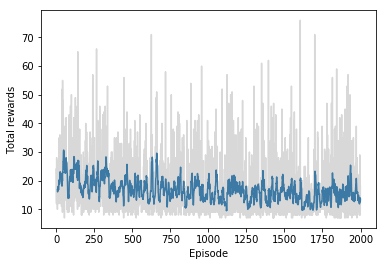

In [24]:
eps, arr = np.array(rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0,0.5,'Fake rewards')

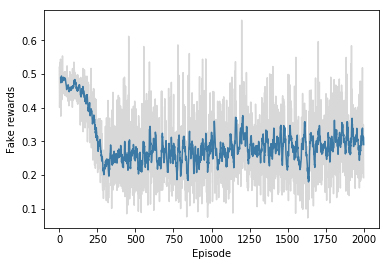

In [25]:
eps, arr = np.array(rewards_fake_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Fake rewards')

Text(0,0.5,'Real rewards')

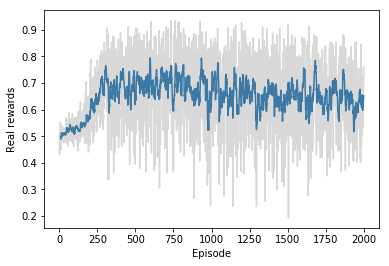

In [26]:
eps, arr = np.array(rewards_real_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Real rewards')

Text(0,0.5,'Q losses')

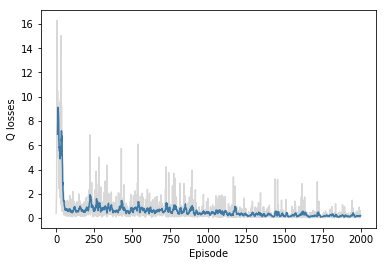

In [27]:
eps, arr = np.array(q_loss_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Q losses')

Text(0,0.5,'G losses')

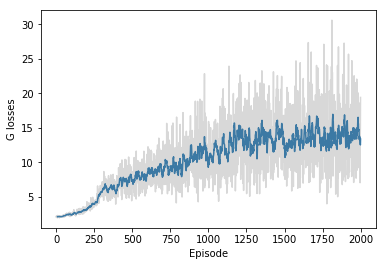

In [28]:
eps, arr = np.array(g_loss_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('G losses')

Text(0,0.5,'D losses')

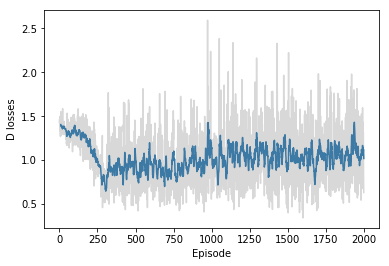

In [29]:
eps, arr = np.array(d_loss_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('D losses')

## Testing

Let's checkout how our trained agent plays the game.

In [55]:
test_episodes = 1
test_max_steps = 20000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000

# # # Create the env after closing it.
# env = gym.make('CartPole-v0')
# # env = gym.make('Acrobot-v1')
env.reset()

with tf.Session() as sess:
    
    # Restore/load the trained model 
    #saver.restore(sess, 'checkpoints/QGAN-cartpole.ckpt')    
    saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    
    # iterations
    for ep in range(test_episodes):
        
        # number of env/rob steps
        t = 0
        while t < test_max_steps:
            
            # Rendering the env graphics
            env.render()
            
            # Get action from DQAN
            feed_dict = {model.states: state.reshape((1, *state.shape))}
            actions_logits = sess.run(model.actions_logits, feed_dict)
            action = np.argmax(actions_logits)
            
            # Take action, get new state and reward
            next_state, reward, done, _ = env.step(action)
            
            # The task is done or not;
            if done:
                t = test_max_steps
                env.reset()
                
                # Take one random step to get the pole and cart moving
                state, reward, done, _ = env.step(env.action_space.sample())
            else:
                state = next_state
                t += 1

INFO:tensorflow:Restoring parameters from checkpoints/model.ckpt


In [56]:
# Closing the env
# WARNING: If you close, you can NOT restart again!!!!!!
env.close()

## Extending this to Deep Convolutional QAN

So, Cart-Pole is a pretty simple game. However, the same model can be used to train an agent to play something much more complicated like Pong or Space Invaders. Instead of a state like we're using here though, you'd want to use convolutional layers to get the state from the screen images.

![Deep Q-Learning Atari](assets/atari-network.png)

I'll leave it as a challenge for you to use deep Q-learning to train an agent to play Atari games. Here's the original paper which will get you started: http://www.davidqiu.com:8888/research/nature14236.pdf.